In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/SkinLesion.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_002

In [ ]:
import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 7 folders inside 'base_dir':

# train_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# val_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)



# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [ ]:
inp = '/content/HAM10000_metadata.csv'
os.listdir(inp)

NotADirectoryError: [Errno 20] Not a directory: '/content/HAM10000_metadata.csv'

In [ ]:
df_data = pd.read_csv(os.path.join(inp, '/content/HAM10000_metadata.csv'))

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [ ]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):

    unique_list = list(df['lesion_id'])

    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [ ]:
df_data['duplicates'].value_counts()

,count
duplicates,
no_duplicates,5514
has_duplicates,4501


In [ ]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [ ]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [ ]:
df_val['dx'].value_counts()

,count
dx,
nv,751
bkl,75
mel,39
bcc,30
akiec,26
vasc,11
df,6


In [ ]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])

    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)

# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [ ]:
df_train['dx'].value_counts()

,count
dx,
nv,5954
mel,1074
bkl,1024
bcc,484
akiec,301
vasc,131
df,109


In [ ]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
base_dir = 'base_dir'

train_dir = os.path.join(base_dir, 'train_dir')

val_dir = os.path.join(base_dir, 'val_dir')

In [ ]:
import os
import shutil

# Get a list of images in each of the two folders
folder_1_files = os.listdir(os.path.join(inp, '/content/ham10000_images_part_1'))
folder_2_files = os.listdir(os.path.join(inp, '/content/ham10000_images_part_2'))

# Ensure image_id is set as the index in df_data
if 'image_id' in df_data.columns:
    df_data.set_index('image_id', inplace=True)

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Function to transfer images
def transfer_images(image_list, source_folder, destination_folder):
    for image in image_list:
        fname = image + '.jpg'

        if image in df_data.index:  # Ensure the image_id exists in df_data
            label = df_data.loc[image, 'dx']
            dst_folder = os.path.join(destination_folder, label)
            os.makedirs(dst_folder, exist_ok=True)  # Create label folder if not exists

            if fname in folder_1_files:
                src = os.path.join(inp, '/content/ham10000_images_part_1', fname)
                dst = os.path.join(dst_folder, fname)
                shutil.copyfile(src, dst)

            elif fname in folder_2_files:
                src = os.path.join(inp, '/content/ham10000_images_part_2', fname)
                dst = os.path.join(dst_folder, fname)
                shutil.copyfile(src, dst)

# Transfer train images
transfer_images(train_list, inp, train_dir)

# Transfer validation images
transfer_images(val_list, inp, val_dir)


In [ ]:
import os

train_dir = "base_dir/train_dir"

# Get all class names (subdirectories inside train_dir)
lesion_classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

# Loop through each class and count images
for lesion in lesion_classes:
    folder_path = os.path.join(train_dir, lesion)

    if os.path.exists(folder_path):  # Ensure folder exists
        print(f"{lesion}: {len(os.listdir(folder_path))} train images")
    else:
        print(f"Warning: Folder {lesion} does not exist!")


nv: 5954 train images
mel: 1074 train images
bkl: 1024 train images
bcc: 484 train images
akiec: 301 train images
vasc: 131 train images
df: 109 train images


In [ ]:
import os

val_dir = "base_dir/val_dir"

# Define lesion class names
lesion_classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

# Loop through each class folder and count images
for lesion in lesion_classes:
    folder_path = os.path.join(val_dir, lesion)

    if os.path.exists(folder_path):  # Check if folder exists
        print(f"{lesion}: {len(os.listdir(folder_path))} validation images")
    else:
        print(f"Warning: Folder '{lesion}' does not exist!")


nv: 751 validation images
mel: 39 validation images
bkl: 75 validation images
bcc: 30 validation images
akiec: 26 validation images
vasc: 11 validation images
df: 6 validation images


In [ ]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# List of classes to augment (excluding 'nv')
class_list = ['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

# Base directory
base_dir = "base_dir"
train_dir = os.path.join(base_dir, "train_dir")

# Define augmentation settings
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

batch_size = 50
num_aug_images_wanted = 6000  # Total number of images we want per class

for img_class in class_list:
    print(f"Augmenting images for class: {img_class}")

    # Define temporary augmentation directories
    aug_dir = "aug_dir"
    img_dir = os.path.join(aug_dir, "img_dir")

    try:
        # Create temporary augmentation directory only if it doesn't exist
        if not os.path.exists(aug_dir):
            os.mkdir(aug_dir)
        if not os.path.exists(img_dir):
            os.mkdir(img_dir)

        # Get current class path
        class_path = os.path.join(train_dir, img_class)

        # Copy images to temporary directory
        img_list = os.listdir(class_path)
        for fname in img_list:
            src = os.path.join(class_path, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)

        # Set up augmentation
        aug_datagen = datagen.flow_from_directory(
            aug_dir,
            target_size=(224, 224),
            batch_size=batch_size,
            save_to_dir=class_path,
            save_format='jpg'
        )

        # Calculate how many images to generate
        num_files = len(img_list)
        num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

        # Generate images
        for i in range(num_batches):
            imgs, labels = next(aug_datagen)

        print(f"Finished augmenting {img_class}. Now has {len(os.listdir(class_path))} images.")

    finally:
        # Ensure temporary directory is deleted even if an error occurs
        if os.path.exists(aug_dir):
            shutil.rmtree(aug_dir)


Augmenting images for class: mel
Found 1074 images belonging to 1 classes.
Finished augmenting mel. Now has 5920 images.
Augmenting images for class: bkl
Found 1024 images belonging to 1 classes.
Finished augmenting bkl. Now has 5920 images.
Augmenting images for class: bcc
Found 484 images belonging to 1 classes.
Finished augmenting bcc. Now has 5858 images.
Augmenting images for class: akiec
Found 301 images belonging to 1 classes.
Finished augmenting akiec. Now has 5217 images.
Augmenting images for class: vasc
Found 131 images belonging to 1 classes.
Finished augmenting vasc. Now has 5290 images.
Augmenting images for class: df
Found 109 images belonging to 1 classes.
Finished augmenting df. Now has 4410 images.


In [ ]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
5920
5920
5858
5217
5290
4410


In [ ]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


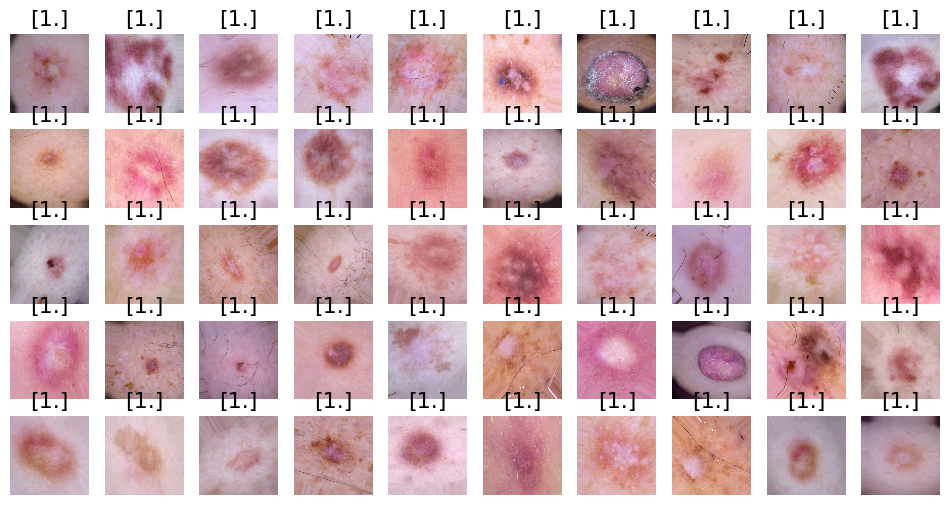

In [ ]:
# plots images with labels within jupyter notebook

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

plots(imgs, titles=labels) # titles=labels will display the image labels

In [ ]:
# Generators

In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:

datagen = ImageDataGenerator(
    preprocessing_function= \
    tf.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [ ]:
# create a copy of a mobilenet model

mobile = tf.keras.applications.mobilenet.MobileNet()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
type(mobile.layers)

list

In [ ]:
# How many layers does MobileNet have?
len(mobile.layers)

91

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# Flatten the output layer to 1 dimension
x = Flatten()(x)
# # Create a new dense layer for predictions
x = Dense(1024, activation='relu')(x)
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 54,617,287 (208.35 MB)

 Trainable params: 54,595,399 (208.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
# Model Training

In [ ]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [ ]:
model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy',
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])


In [ ]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 2.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [ ]:
import math

# Ensure steps are integers
train_steps = math.ceil(len(train_batches) / batch_size)
val_steps = math.ceil(len(valid_batches) / batch_size)

# Save model in `.keras` format (required in newer TensorFlow versions)
filepath = "model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

# Train the model
history = model.fit(
    train_batches,
    steps_per_epoch=train_steps,  # Ensure it's an integer
    class_weight=class_weights,
    validation_data=valid_batches,
    validation_steps=val_steps,  # Ensure it's an integer
    epochs=10,
    verbose=1,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.1987 - loss: 172.4985 - top_2_accuracy: 0.4712 - top_3_accuracy: 0.6251
Epoch 1: val_top_3_accuracy improved from -inf to 1.00000, saving model to model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - categorical_accuracy: 0.1987 - loss: 171.1652 - top_2_accuracy: 0.4704 - top_3_accuracy: 0.6240 - val_categorical_accuracy: 0.6500 - val_loss: 132.7011 - val_top_2_accuracy: 0.9500 - val_top_3_accuracy: 1.0000 - learning_rate: 0.0100
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.1853 - loss: 2.3136 - top_2_accuracy: 0.3296 - top_3_accuracy: 0.4798
Epoch 2: val_top_3_accuracy did not improve from 1.00000
78/78 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - categorical_accuracy: 0.1852 - loss: 2.3135 - top_2_accuracy: 0.3295 - top_3_accuracy: 0.4795 - val_categorical_accuracy: 0.7000 - val_loss: 77.0319 - val_top_2_accuracy: 0.8500 - val_top_3_accuracy: 1.0000 - learning_rate: 0.0100
Epoch 3/10
78/7

In [ ]:
# Evaluate the model

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'compile_metrics']

In [ ]:
# Evaluate the model on the test set
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = model.evaluate(
    test_batches,  # Use the test dataset
    steps=len(df_val)  # Ensure the number of steps matches the dataset size
)

# Print evaluation metrics
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Categorical Accuracy: {val_cat_acc:.4f}')
print(f'Validation Top-2 Accuracy: {val_top_2_acc:.4f}')
print(f'Validation Top-3 Accuracy: {val_top_3_acc:.4f}')


938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 74ms/step - categorical_accuracy: 0.0745 - loss: 2.0123 - top_2_accuracy: 0.2611 - top_3_accuracy: 0.3628
Validation Loss: 2.0407
Validation Categorical Accuracy: 0.0416
Validation Top-2 Accuracy: 0.1215
Validation Top-3 Accuracy: 0.1546


In [ ]:
# Load the best model weights
model.load_weights("model.keras")  # Change from .h5 to .keras

# Evaluate the model on the test set
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = model.evaluate(
    test_batches,  # Use the test dataset
    steps=len(df_val)  # Ensure the number of steps matches the dataset size
)

# Print evaluation metrics
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Categorical Accuracy: {val_cat_acc:.4f}')
print(f'Validation Top-2 Accuracy: {val_top_2_acc:.4f}')
print(f'Validation Top-3 Accuracy: {val_top_3_acc:.4f}')

938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 75ms/step - categorical_accuracy: 0.4616 - loss: 301.2629 - top_2_accuracy: 0.8588 - top_3_accuracy: 1.0000
Validation Loss: 109.7125
Validation Categorical Accuracy: 0.7100
Validation Top-2 Accuracy: 0.9531
Validation Top-3 Accuracy: 1.0000


In [ ]:
# Plotting the training curves

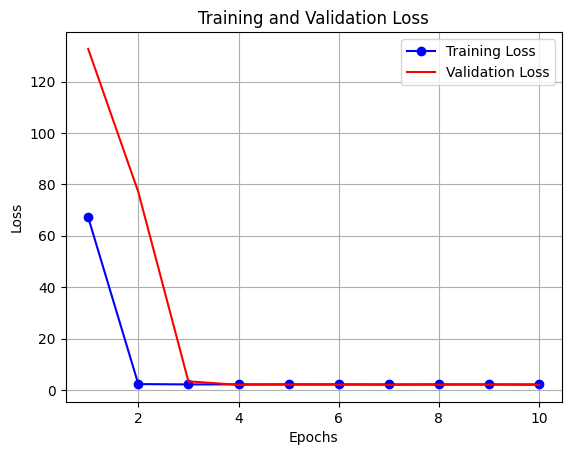

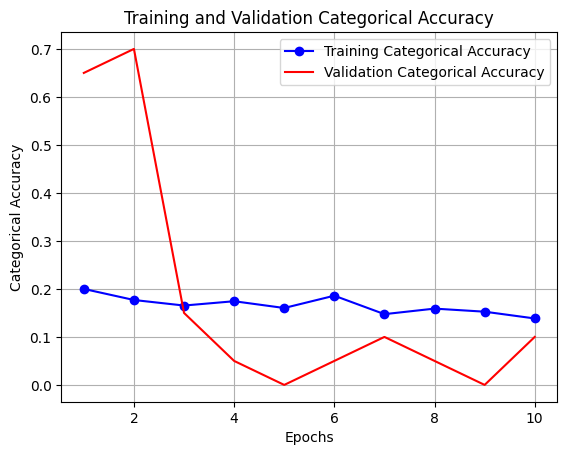

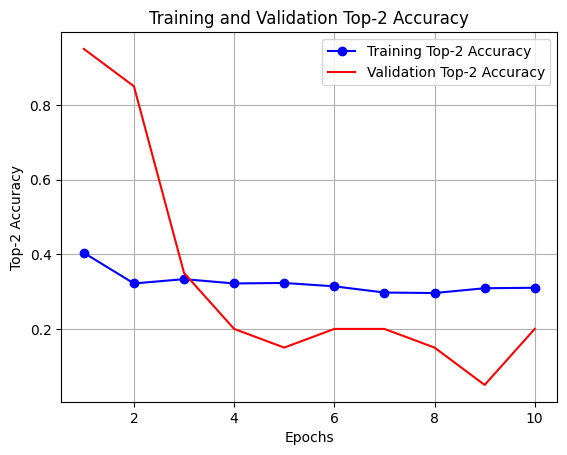

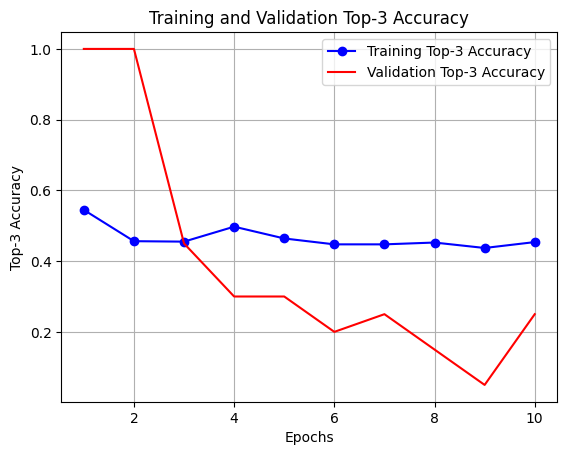

In [ ]:
import matplotlib.pyplot as plt

# Get the minimum length to ensure all lists match
min_epochs = min(len(history.history.get('loss', [])),
                 len(history.history.get('val_loss', [])),
                 len(history.history.get('categorical_accuracy', [])),
                 len(history.history.get('val_categorical_accuracy', [])),
                 len(history.history.get('top_2_accuracy', [])),
                 len(history.history.get('val_top_2_accuracy', [])),
                 len(history.history.get('top_3_accuracy', [])),
                 len(history.history.get('val_top_3_accuracy', [])))

# Trim all lists to the minimum length
epochs = range(1, min_epochs + 1)
loss = history.history.get('loss', [])[:min_epochs]
val_loss = history.history.get('val_loss', [])[:min_epochs]
acc = history.history.get('categorical_accuracy', [])[:min_epochs]
val_acc = history.history.get('val_categorical_accuracy', [])[:min_epochs]
train_top2_acc = history.history.get('top_2_accuracy', [])[:min_epochs]
val_top2_acc = history.history.get('val_top_2_accuracy', [])[:min_epochs]
train_top3_acc = history.history.get('top_3_accuracy', [])[:min_epochs]
val_top3_acc = history.history.get('val_top_3_accuracy', [])[:min_epochs]

# Function to plot metrics
def plot_metric(metric_values, val_metric_values, metric_name, title):
    if metric_values and val_metric_values:
        plt.figure()
        plt.plot(epochs, metric_values, 'bo-', label=f'Training {metric_name}')
        plt.plot(epochs, val_metric_values, 'r-', label=f'Validation {metric_name}')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid()
        plt.show()

# Plot Loss
plot_metric(loss, val_loss, "Loss", "Training and Validation Loss")

# Plot Categorical Accuracy
plot_metric(acc, val_acc, "Categorical Accuracy", "Training and Validation Categorical Accuracy")

# Plot Top-2 Accuracy
plot_metric(train_top2_acc, val_top2_acc, "Top-2 Accuracy", "Training and Validation Top-2 Accuracy")

# Plot Top-3 Accuracy
plot_metric(train_top3_acc, val_top3_acc, "Top-3 Accuracy", "Training and Validation Top-3 Accuracy")


In [ ]:
# Confusion Matrix

In [ ]:
test_labels = test_batches.classes

In [ ]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [ ]:
_# Print the label associated with each class
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [ ]:
predictions = model.predict(test_batches, steps=len(df_val), verbose=1)

938/938 ━━━━━━━━━━━━━━━━━━━━ 73s 76ms/step


In [ ]:
predictions.shape

(938, 7)

In [ ]:
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [ ]:
test_labels.shape

(938,)

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[  0   0   5   0   0  21   0]
 [  0   0   7   0   0  23   0]
 [  0   0  11   0   0  63   1]
 [  0   0   1   0   0   5   0]
 [  0   0   9   0   0  30   0]
 [  0   0  95   0   0 655   1]
 [  0   0   0   0   0  11   0]]


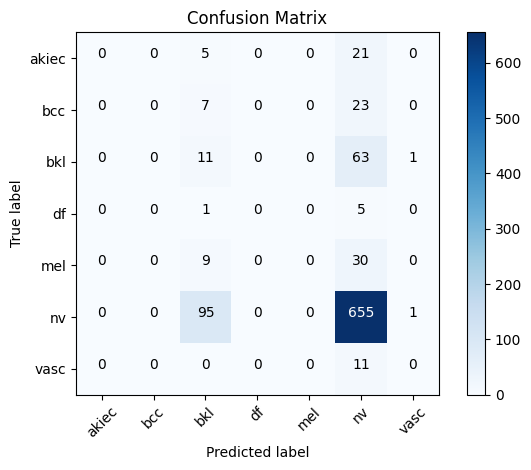

In [ ]:
# Define the labels of the class indices. These need to match the
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
model.save("/content/mobilenet_model.h5")

In [ ]:
!pip install gradio tensorflow pdfkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
to

In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2
import pdfkit
from PIL import Image
import os

In [ ]:
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model("mobilenet_model.h5", custom_objects={"top_2_accuracy": top_2_accuracy, "top_3_accuracy": top_3_accuracy})

# Save in HDF5 (.h5) format
model.save("mobilenet_model.h5")

In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.saving import register_keras_serializable

# ✅ Step 1: Define and Register `top_2_accuracy` and `top_3_accuracy`
@register_keras_serializable()
def top_2_accuracy(y_true, y_pred):
    return TopKCategoricalAccuracy(k=2)(y_true, y_pred)

@register_keras_serializable()
def top_3_accuracy(y_true, y_pred):
    return TopKCategoricalAccuracy(k=3)(y_true, y_pred)

# ✅ Step 2: Load Model with Both Custom Metrics
model_path = "/content/mobilenet_model.h5"  # Ensure the correct path

try:
    model = tf.keras.models.load_model(
        model_path,
        custom_objects={"top_2_accuracy": top_2_accuracy, "top_3_accuracy": top_3_accuracy}
    )
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")


✅ Model loaded successfully!


In [ ]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.3 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

# Global variable for model
model = None

# Define class labels
class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Function to load the model
def load_model():
    global model
    model = tf.keras.models.load_model("/content/mobilenet_model.h5")
    return "Model Loaded Successfully!"

# Function to make predictions and return bar chart
def predict(image):
    global model
    if model is None:
        return "Error: Model not loaded!"

    image = image.resize((224, 224))
    image = np.array(image) / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)[0]  # Get predictions
    predicted_class = class_labels[np.argmax(predictions)]

    # Generate bar chart
    fig, ax = plt.subplots()
    ax.bar(class_labels, predictions, color='skyblue')
    ax.set_ylabel("Probability")
    ax.set_title(f"Prediction: {predicted_class}")
    plt.xticks(rotation=45)

    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)

    return Image.open(buf)

# Gradio Interface
demo = gr.Blocks()

with demo:
    gr.Markdown("# 🩺 Skin Lesion Classification")
    gr.Markdown("Upload an image and get a probability distribution of the predicted skin lesion type.")

    with gr.Row():
        load_btn = gr.Button("Load Model")
        model_status = gr.Textbox(label="Model Status", interactive=False)

    load_btn.click(load_model, outputs=model_status)

    with gr.Row():
        image_input = gr.Image(type="pil", label="Upload Image")
        output_plot = gr.Image(label="Prediction Probabilities")

    predict_btn = gr.Button("Predict")
    predict_btn.click(predict, inputs=image_input, outputs=output_plot)

# Launch the Gradio app
demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7d9b68d122a3c5d1c1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

# Load Model
def load_model():
    global model
    try:
        model_path = "/content/mobilenet_model.keras"
        model = tf.keras.models.load_model(model_path, custom_objects={})
        return "Model Loaded Successfully!"
    except Exception as e:
        return f"Error loading model: {str(e)}"

# Define class labels
class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Prediction Function
def predict(image):
    global model
    if model is None:
        return "Error: Model not loaded!"

    # Convert image to NumPy array
    image = image.resize((224, 224))
    image_np = np.array(image)
    print("\n[DEBUG] Raw Image Array (Before Normalization):", image_np.flatten()[:10])  # Print first 10 pixel values

    # Normalize and add batch dimension
    image_np = image_np / 255.0
    image_np = np.expand_dims(image_np, axis=0)
    print("\n[DEBUG] Processed Image Array:", image_np.flatten()[:10])  # Print first 10 processed pixel values

    # Make Prediction
    predictions = model.predict(image_np)[0]
    print("\n[DEBUG] Raw Model Predictions:", predictions)

    # Check if the model is outputting a fixed probability
    if np.allclose(predictions, predictions[0]):
        print("\n[DEBUG] Warning: Model outputs similar probabilities for all classes!")
        return "Error: Model seems to predict the same probabilities for all inputs."

    # Get highest probability class
    predicted_class = class_labels[np.argmax(predictions)]

    # Generate Probability Bar Chart
    fig, ax = plt.subplots()
    ax.bar(class_labels, predictions, color='blue')
    ax.set_ylabel("Probability")
    ax.set_title("Prediction Probabilities")
    plt.xticks(rotation=45)

    # Convert Plot to Image
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    bar_chart = Image.open(buf)

    return predicted_class, bar_chart

# Gradio Interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Text(label="Predicted Class"), gr.Image()],
    title="Skin Lesion Classification",
    description="Upload an image to classify the skin lesion."
)

# Load Model Before Launch
load_model()

# Launch Gradio App
demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://959db23e96447d29b3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import pandas as pd

metadata = pd.read_csv("HAM10000_metadata.csv")
print(metadata["dx"].value_counts())


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
